In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.7 MB/s eta 0:00:00


In [2]:
import scipy.io as spio
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import mne
from mne.io import RawArray
from mne import create_info
from mne.channels import make_standard_montage

path_data = 'MyDrive/Colab Notebooks/data/'
path_mount = '/content/drive/'

In [3]:
from google.colab import drive
drive.mount(path_mount)

Mounted at /content/drive/


In [4]:
subjects = ["S1", "S2", "S3", "S4", "S5"]
unicorn_channels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]
subject = "S3"
file_path = os.path.join(path_mount, path_data, "json", subject)
df = pd.read_json(file_path + ".json")
trigger = np.array(df.trigger)

eeg = df[unicorn_channels].to_numpy()
chs = unicorn_channels
fs = df['sampling_rate'].values[0]


Creating RawArray with float64 data, n_channels=8, n_times=60955
    Range : 0 ... 60954 =      0.000 ...   243.816 secs
Ready.
60955
[ 1267  1310  1354 ... 59471 59516 59559] 1200 [-1 -1 -1 ... -1 -1 -1] 1200
Ones [1. 1. 1. ... 1. 1. 1.] 1050
Threes [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3.] 150
stim_data =  [[0. 0. 0. ... 0. 0. 0.]]
Creating RawArray with float64 data, n_channels=1, n_times=60955
    Range : 0 ... 60954 =      0.000 ...   243.816 secs
Ready.
stim_raw =  <RawArray | 1 x 60955 (243.8 s), ~483 kB, data loaded>
Using matplotlib as 2D backend.


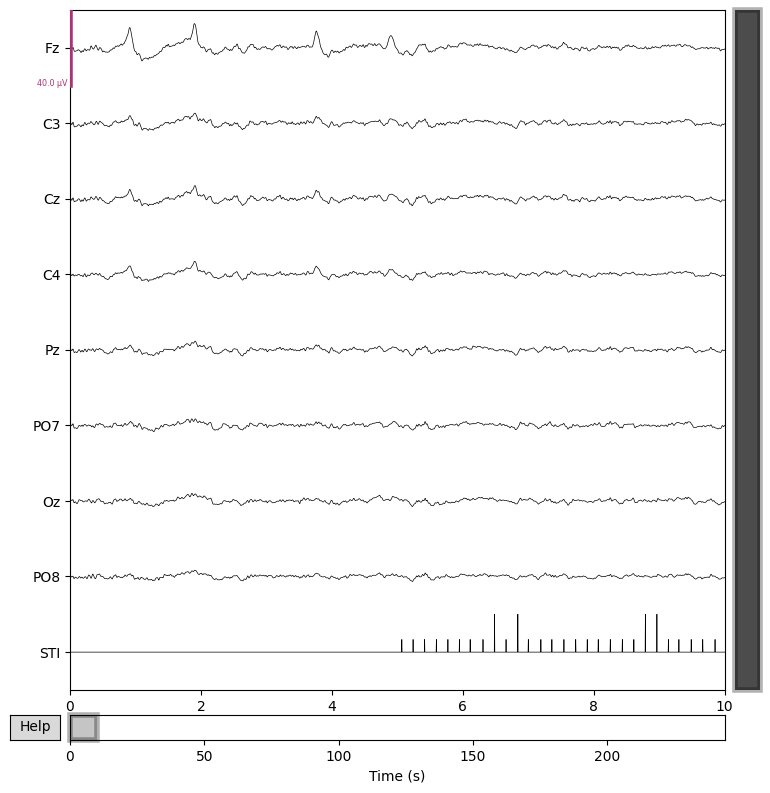

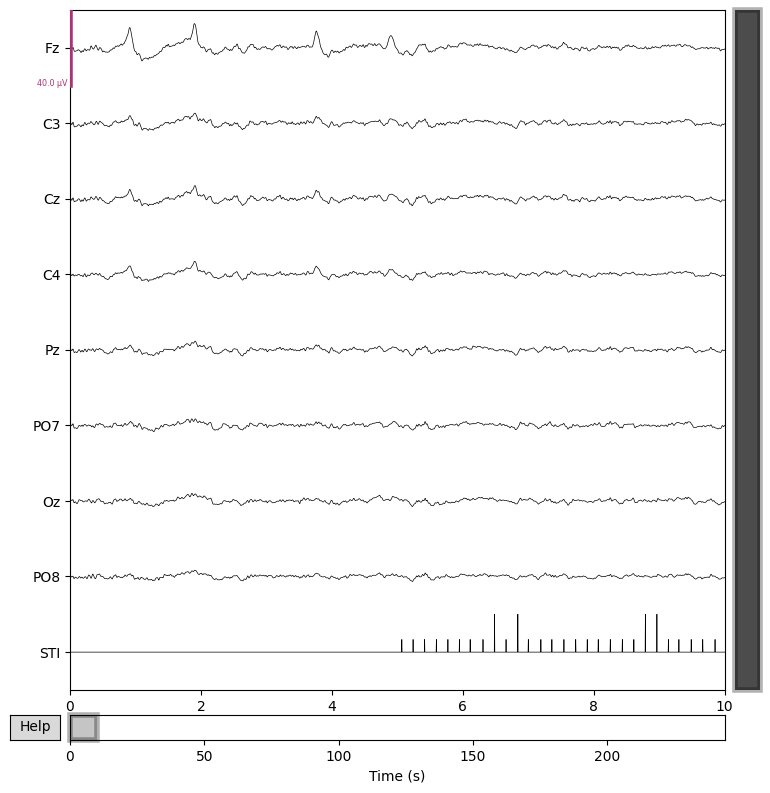

In [5]:
thisRec = RawArray(eeg.T/1e7, create_info(chs, fs, ch_types='eeg'))

# Get event indexes where value is not 0, i.e. -1 or 1
pos = np.where(trigger != 0)[0]

print(len(trigger))
# Filter 0 values from the trigger array
y = trigger[trigger != 0]
print(pos, len(pos), y, len(y))

# Create the stimuli channel 
stim_data = np.zeros((1,thisRec.n_times))

# MNE works with absolute values of labels so -1 and +1 would result in only one kind of event
# that's why we add 2 and obtain 1 and 3 as label values
stim_data[0,pos] = y + 2 
ones = stim_data[stim_data == 1]
threes = stim_data[stim_data == 3]
print("Ones", ones, len(ones))
print("Threes", threes, len(threes))
print('stim_data = ', stim_data)
stim_raw = RawArray(stim_data, create_info(['STI'], thisRec.info['sfreq'], ch_types=['stim']))
print('stim_raw = ', stim_raw)
# adding the stimuli channel (as a Raw object) to our EEG Raw object
thisRec.add_channels([stim_raw])

# Set the standard 10-20 montage
montage = make_standard_montage('standard_1020')
thisRec.set_montage(montage)

thisRec.plot()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 6 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.7s.
Creating RawArray with float64 data, n_channels=6, n_times=60955
    Range : 0 ... 60954 =      0.000 ...   243.816 secs
Ready.


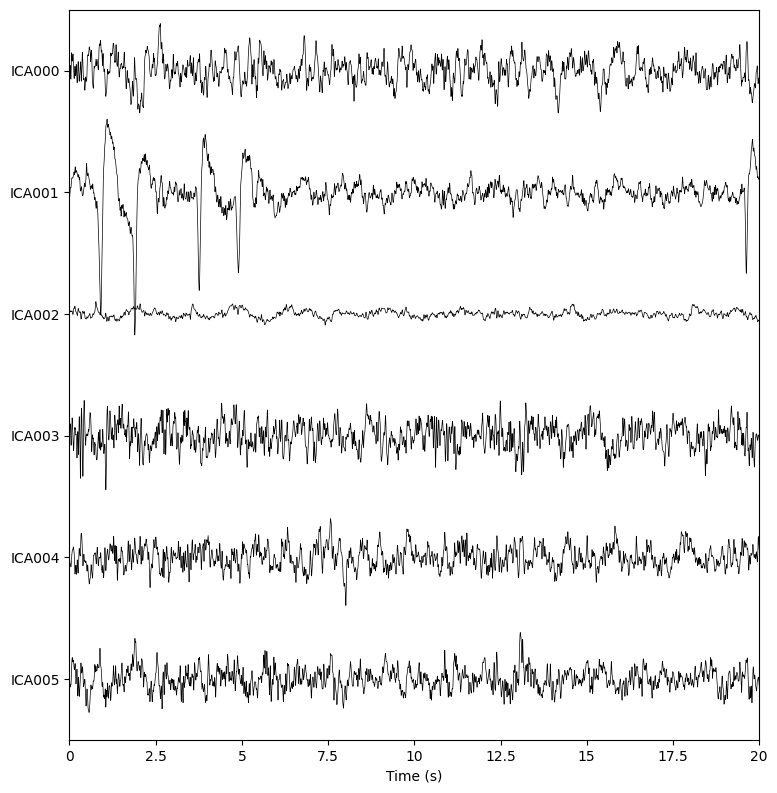

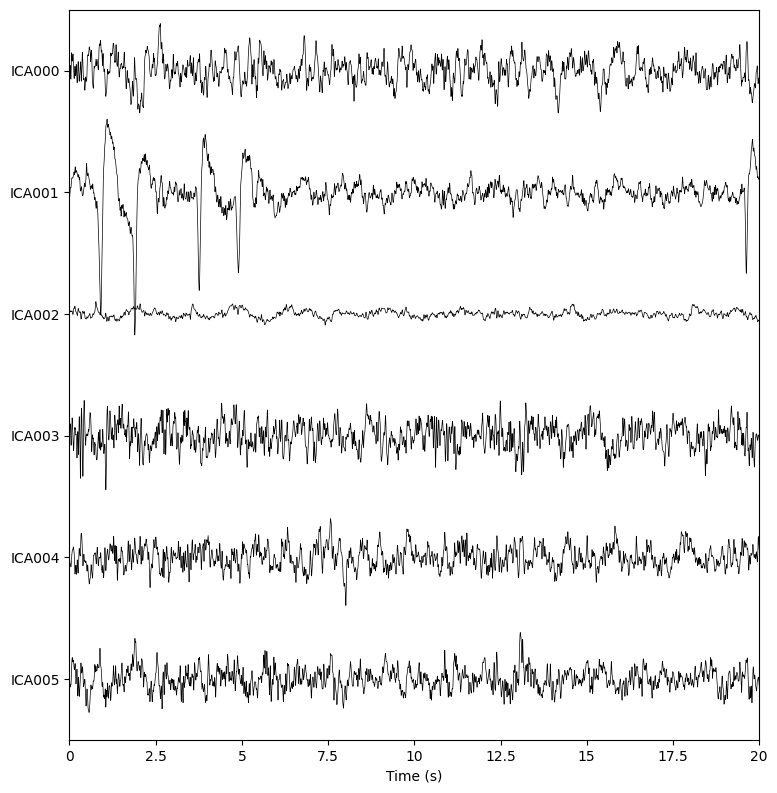

In [6]:
# Preprocessing with ICA
from mne.preprocessing import (ICA, corrmap)

filt_raw = thisRec.copy().filter(l_freq=1., h_freq=None)
ica = ICA(n_components=6, max_iter='auto', random_state=1024)
ica.fit(filt_raw)
ica.plot_sources(thisRec, show_scrollbars=False)

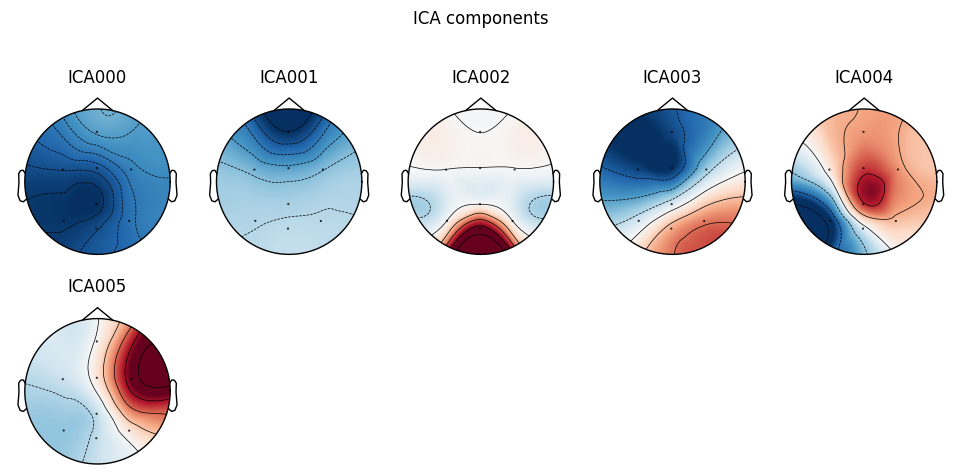

[<MNEFigure size 975x496 with 6 Axes>]

In [7]:
ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


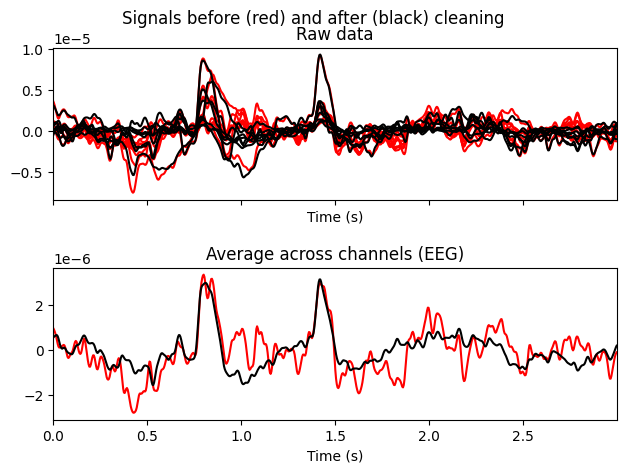

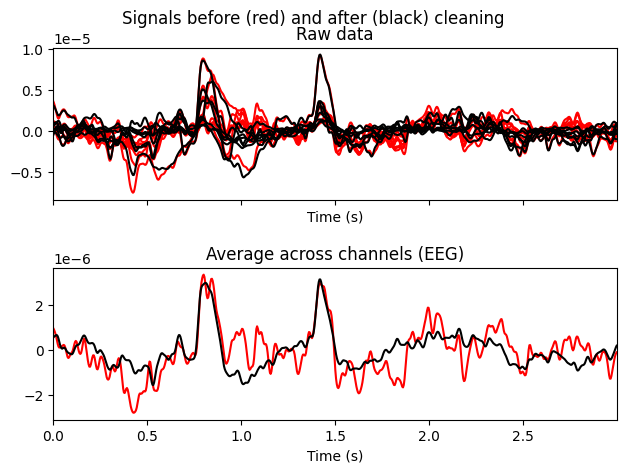

In [ ]:
ica.plot_overlay(thisRec, exclude=[0], picks='eeg')

In [ ]:
ica.exclude = []  # indices chosen based on various plots above

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


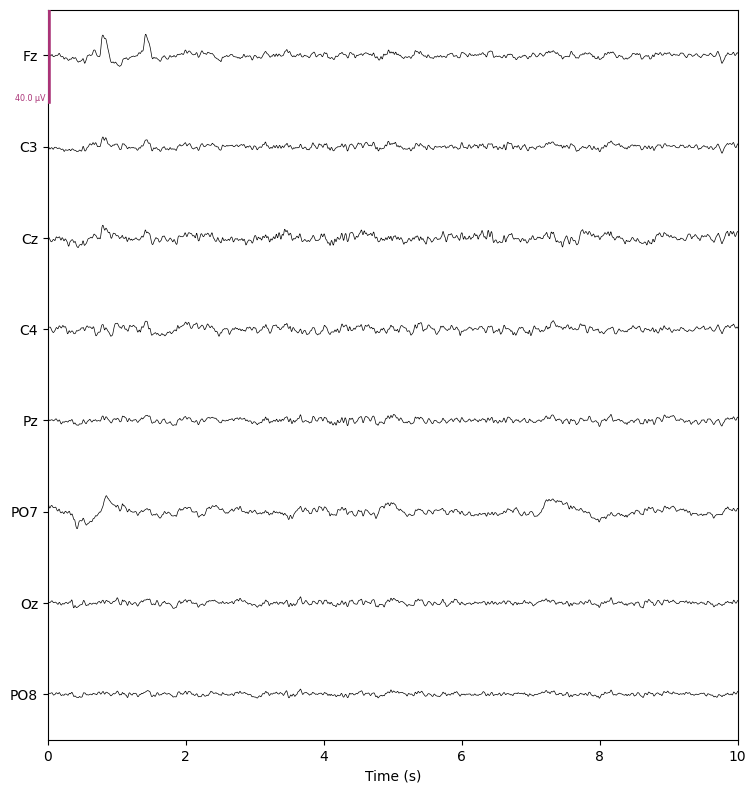

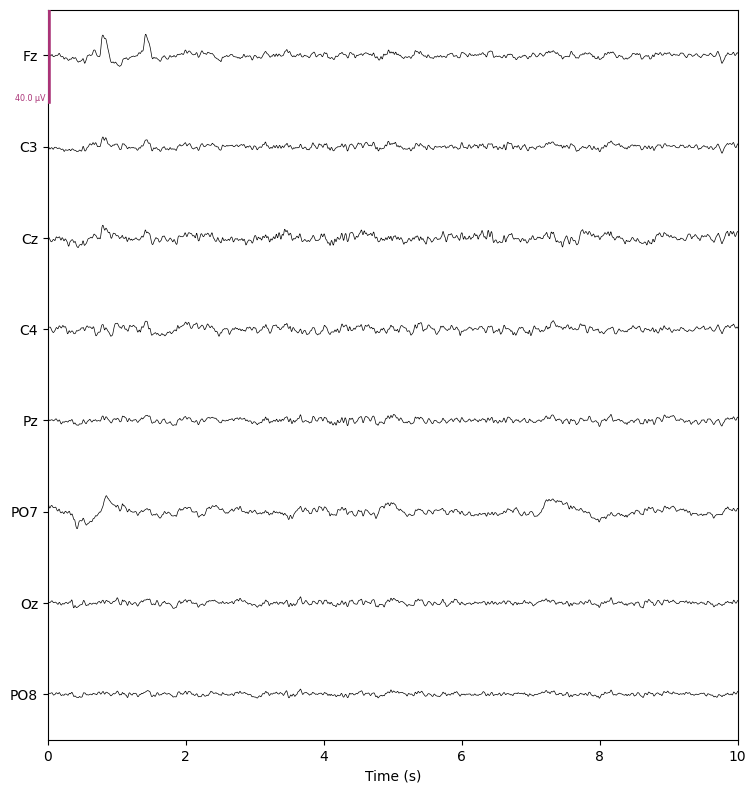

In [ ]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = thisRec.copy()
ica.apply(reconst_raw)

thisRec.plot(n_channels=len(unicorn_channels),
         show_scrollbars=False)
reconst_raw.plot(n_channels=len(unicorn_channels),
                 show_scrollbars=False)


file_path = os.path.join(path_mount, path_data,"preprocessed", subject + '_eeg') + '.fif'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 sec)

Overwriting existing file.
Writing /content/drive/MyDrive/Colab Notebooks/data/preprocessed/S1_eeg.fif
Closing /content/drive/MyDrive/Colab Notebooks/data/preprocessed/S1_eeg.fif
[done]
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


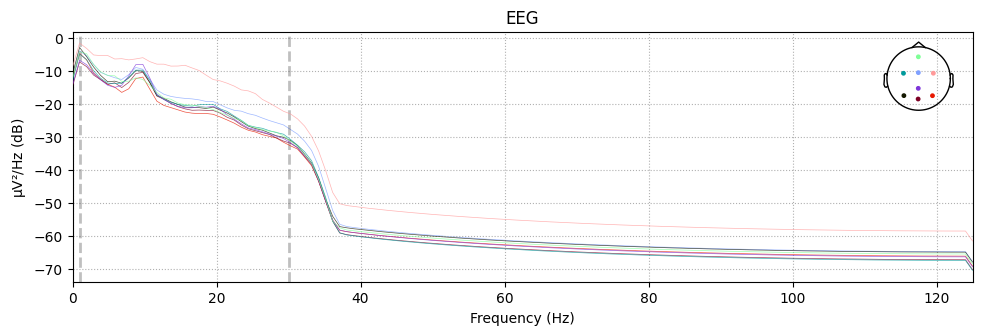

In [ ]:
filtered = reconst_raw.copy() # the method filters the signal in-place, so this time I 
                      # want to preserve the orignial signal and filter just a 
                      # temporary copy of it

# Apply band-pass filtering
filtered.filter(1,30) # easy huh?!

# Save preprocessed data
filtered.save(file_path, fmt='double', overwrite=True)

pxx_filt = filtered.compute_psd()
pxx_filt.plot()

1200 events found
Event IDs: [1 3]


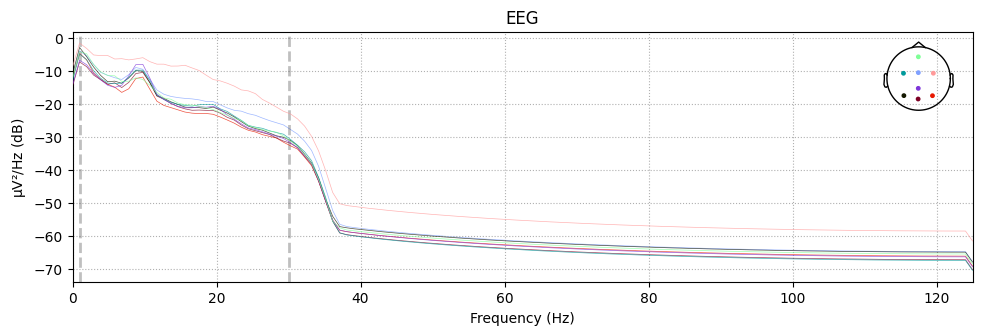

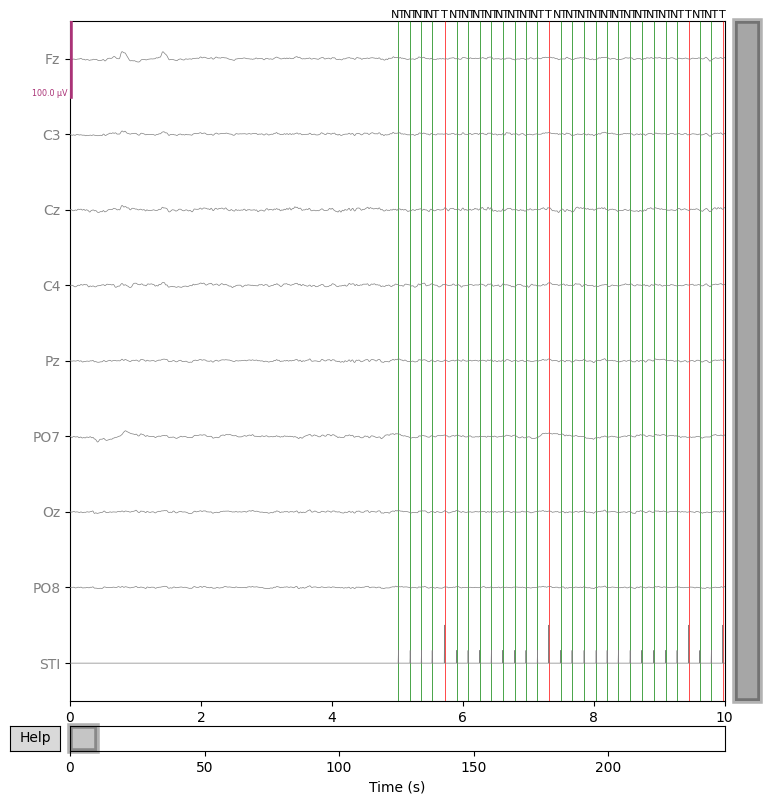

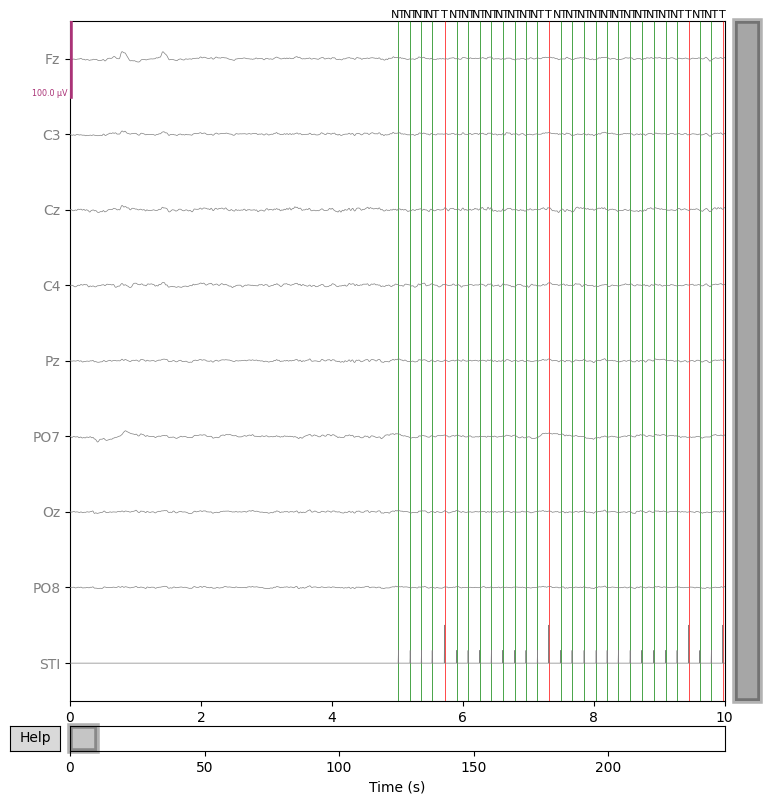

In [ ]:
from mne import find_events


# extracting events from the stimuli channel and giving thema a class name with the dict ev_ids
evs = find_events(filtered, stim_channel='STI')
ev_ids = {'NT': 1, 'T': 3}

# Easily visualize events along the signal plot
filtered.plot(events = evs, event_id = ev_ids, event_color ={1:'g',3:'r'}, color = 'Gray',
             block = True, clipping=None, scalings=50e-6)

Not setting metadata
1200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 351 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 351 original time points ...


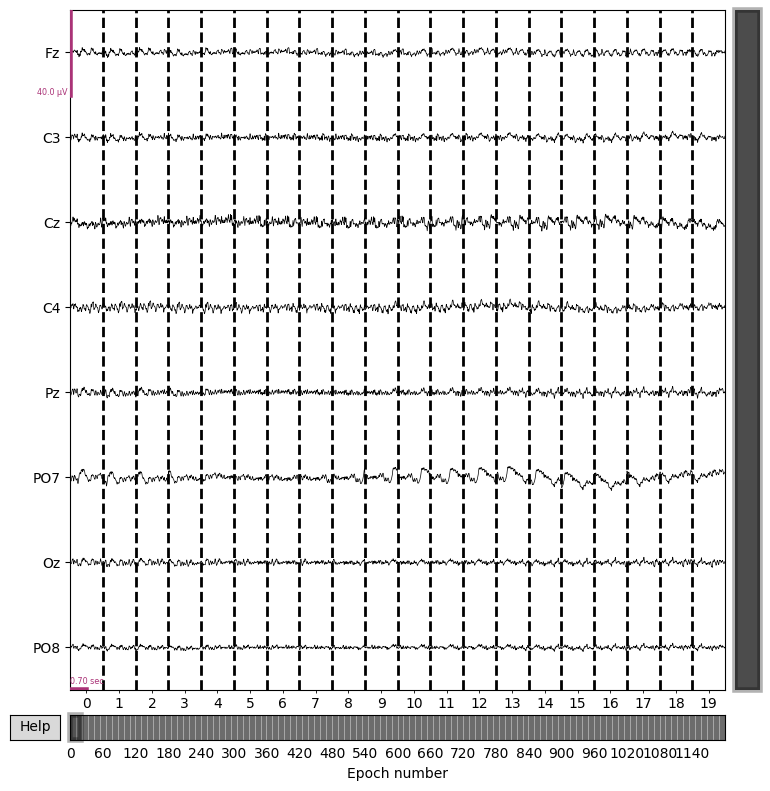

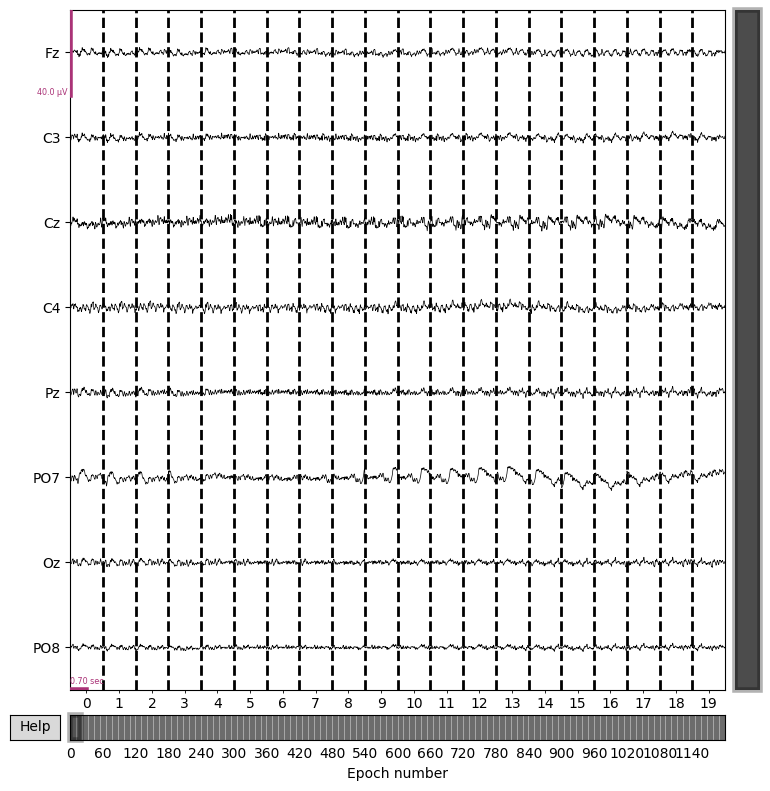

In [ ]:

# creating the Epochs object combining EEG data and events info
from mne import Epochs
eps = Epochs(filtered, evs, event_id=ev_ids, 
             tmin=-.6, tmax=0.8, baseline=(-.6,-.1)) 
            # This last parameters define the time window extracted as single epoch relatively to
            # the single event, 'baseline' is the timespan from which the data for the baseline 
            # correction is extracted.
            # In this case the epoch starts at the event and ends 2.5 s after, and the baseline 
            # corresponds to the first 0.5 s of the epoch

eps.plot(block=True) # .plot() method for Epoch objects has not clipping parameter

In [ ]:
epochs_target = eps["T"]
e = epochs_target.to_data_frame()
e = e[e["STI"] == "NT"]
#epochs_target.plot()
e

Using data from preloaded Raw for 150 events and 351 original time points ...


,time,condition,epoch,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,STI


Using data from preloaded Raw for 150 events and 351 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


Applying baseline correction (mode: mean)
No baseline correction applied


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s finished


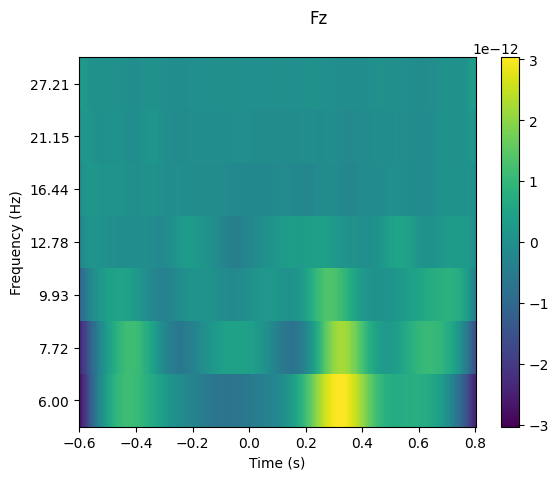

No baseline correction applied


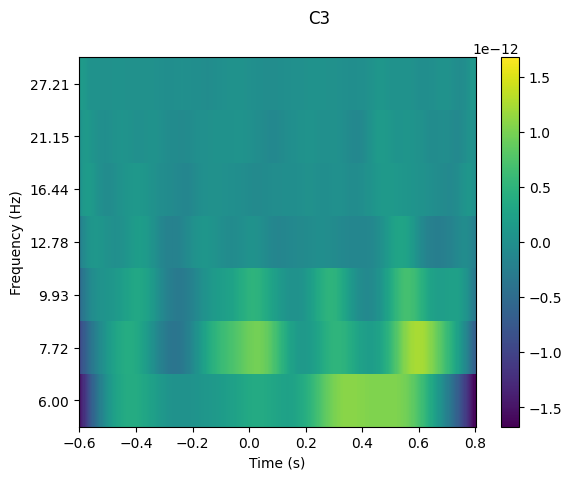

No baseline correction applied


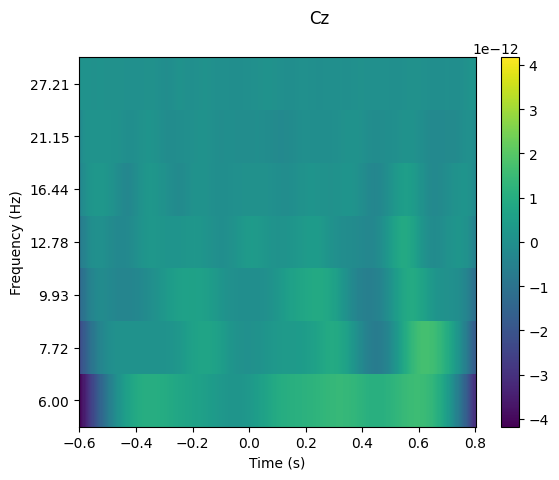

No baseline correction applied


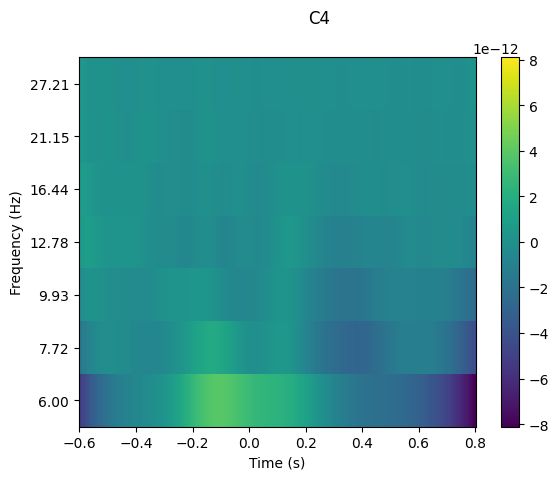

No baseline correction applied


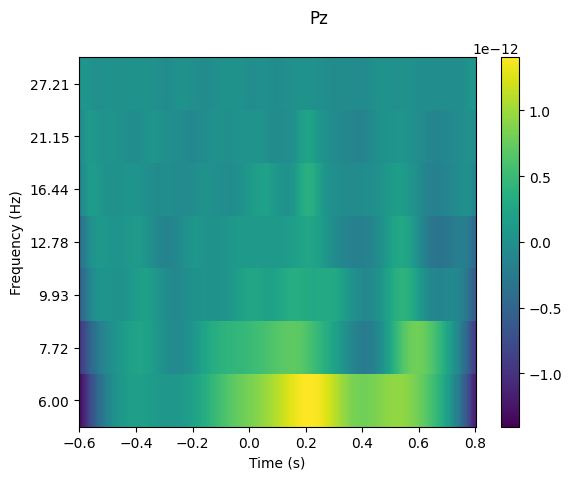

No baseline correction applied


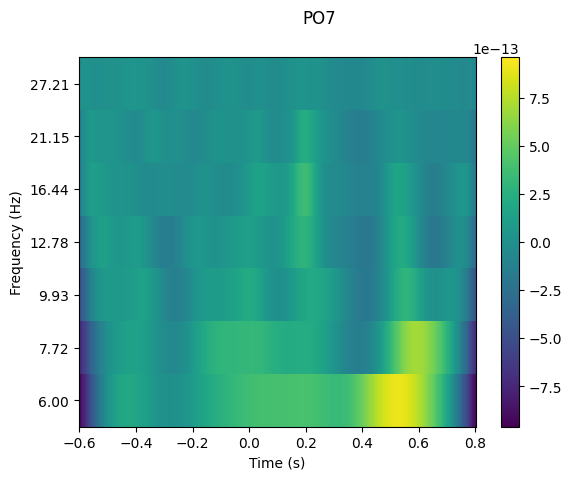

No baseline correction applied


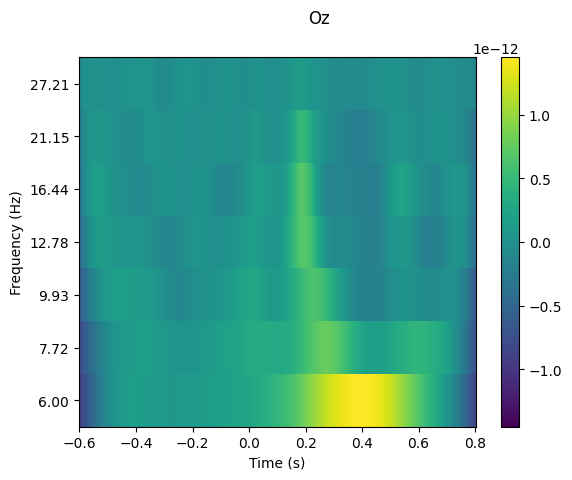

No baseline correction applied


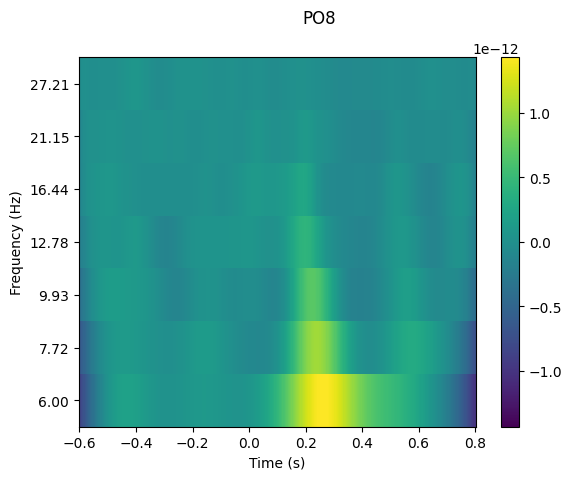

In [ ]:
from mne.time_frequency import tfr_morlet

freqs = np.logspace(*np.log10([6, 35]), num=8)

# create a time-frequency representation using Morlet wavelets
tfr, itc = tfr_morlet(epochs_target, freqs, n_cycles=5, average=True, return_itc=True)

# Apply baseline correction using mean power in the time range of interest
baseline=(-.6,-.1)
tfr.apply_baseline(baseline, mode='mean')


for channel in unicorn_channels:  
  tfr.plot(mode='logratio', picks=channel, fmin=2, fmax=30, cmap='viridis', title=channel)

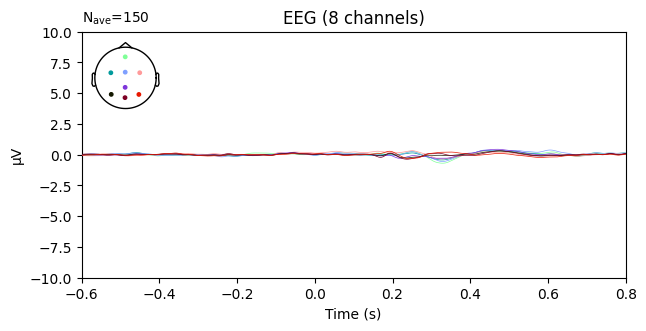

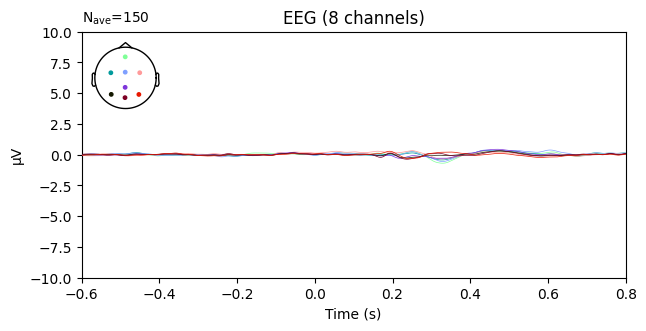

In [ ]:
# Compute the grand average ERP waveform across all target epochs
evoked = epochs_target.average()
#evoked.add_channels(chs)
# Plot the ERP waveform at Pz and Cz electrodes
evoked.plot(spatial_colors=True, picks="eeg", ylim=dict(eeg=[-10, 10]))

In [ ]:
epo_spectrum = epochs_target.compute_psd()
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f'\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}')
epo_spectrum

Using data from preloaded Raw for 150 events and 351 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows

PSDs shape: (150, 8, 176), freqs shape: (176,)


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Epochs
Number of epochs,150
Dims,"epoch, channel, freq"
Estimation method,multitaper
Number of channels,8
Number of frequency bins,176
Frequency range,0.00 – 124.64 Hz


    Using multitaper spectrum estimation with 7 DPSS windows


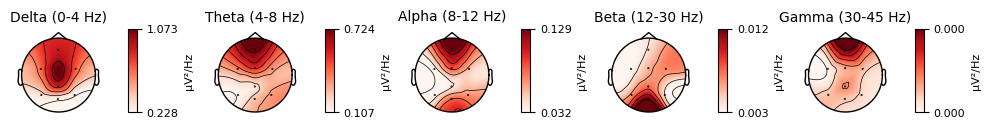

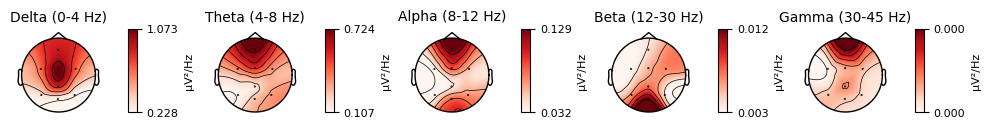

In [ ]:
evoked = epochs_target.average()
evk_spectrum = evoked.compute_psd()
evk_spectrum.plot_topomap(ch_type='eeg', agg_fun=np.median)